<a href="https://www.kaggle.com/code/ericanacletoribeiro/cicids2017-ml-models-comparison-unsupervised?scriptVersionId=226635116" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Unsupervised Learning Models for Anomaly-Based Intrusion Detection

This Jupyter Notebook focuses on training and evaluating unsupervised machine learning models for anomaly-based intrusion detection. It builds upon the preprocessed CICIDS2017 dataset, prepared in the **data preprocessing [notebook available here](https://www.kaggle.com/code/ericanacletoribeiro/cicids2017-comprehensive-data-processing-for-ml)** and continuous the performance analysis started on the **[supervised learning notebook](https://www.kaggle.com/code/ericanacletoribeiro/cicids2017-ml-models-comparison-supervised)**. 

The broader goal is to develop a Network Intrusion Detection System (NIDS) prototype capable of identifying a range of network attacks, such as DoS, PortScan, and Brute Force, while balancing detection accuracy with computational efficiency. This is particularly critical in resource-constrained environments, focus of the project. The complete pipeline is **documented on [Github](https://github.com/anacletu/ml-intrusion-detection-cicids2017)**.

**Models Being Evaluated:**

* **Supervised Learning ([Previous Notebook](https://www.kaggle.com/code/ericanacletoribeiro/cicids2017-ml-models-comparison-supervised)):**
    * Random Forest
    * XGBoost
    * _k_-NN

* **Unsupervised Learning (This Notebook):**
    * Isolation Forest
    * K-means

**Evaluation Strategy:**

The approach here is to train the models using a binary classification approach, where anomalous traffic should be identified as outliers by the models. Evaluation is performed by applying the trained model to a test set to assess its ability to distinguish between normal and anomalous behavior, based on a reserved ground truth. Key performance metrics include ROC-AUC, precision, recall, and F1-score, providing essential insights into the model’s effectiveness in detecting anomalies. These metrics also help determine the model’s suitability for real-time deployment in resource-constrained networks.

This notebook presents the training process, hyperparameter tuning, and comparative analysis of the selected binary classification models.

In [1]:
# Installing extra components
!pip install memory_profiler
!pip install psutil

In [2]:
# Importing the relevant libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans
from sklearn.preprocessing import RobustScaler

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_curve, davies_bouldin_score, calinski_harabasz_score

import time
import psutil
import threading
from memory_profiler import memory_usage

import joblib

# Helper Functions

In [3]:
# Apply Isolation Forest with resource measurements
def apply_if(X_train, y_train=None, best_params=None, random_state=42, n_jobs=-1):
    """
    Apply Isolation Forest with resource measurements, including memory, training time, and CPU usage.

    Parameters:
        X_train: Training features.
        y_train: Training labels (not used for training but needed for consistent interface).
        best_params: Dictionary of best parameters for Isolation Forest.
        random_state: Random state for reproducibility.
        n_jobs: Number of jobs for parallel processing.

    Returns:
        measurement_if: Dictionary of memory, training time, and CPU usage.
        if_model: Trained Isolation Forest model.
    """
    
    measurement_if = {}

    # Default to empty dictionary if best_params is not provided
    best_params = best_params or {}

    if_model = IsolationForest(**best_params, random_state=random_state, n_jobs=n_jobs)
    
    # Function to monitor CPU usage during training
    cpu_usage = []
    stop_flag = threading.Event()

    def monitor_cpu():
        while not stop_flag.is_set():
            cpu_usage.append(psutil.cpu_percent(interval=0.1))

    # Function to train the model
    def train_model():
        if_model.fit(X_train)

    try:
        # Start CPU monitoring in a separate thread
        cpu_thread = threading.Thread(target=monitor_cpu)
        cpu_thread.start()

        # Measure memory usage and training time
        start_time = time.time()
        train_memory_if = max(memory_usage((train_model,)))  # Measure peak memory usage
        training_time = time.time() - start_time

        # Stop CPU monitoring
        stop_flag.set()
        cpu_thread.join()

        # Add measurements
        measurement_if['Memory Usage (MB)'] = train_memory_if
        measurement_if['Training Time (s)'] = training_time
        measurement_if['Peak CPU Usage (%)'] = max(cpu_usage)
        measurement_if['Average CPU Usage (%)'] = sum(cpu_usage) / len(cpu_usage) if cpu_usage else 0

        return measurement_if, if_model

    except Exception as e:
        print(f"Error during Isolation Forest training: {e}")
        return None, None

In [4]:
# Apply K-means with resource measurements
def apply_kmeans(X, n_clusters=7, random_state=42, n_init='auto'):
    """
    Apply K-Means with resource measurements, including memory, training time, and CPU usage.
    
    Parameters:
        X: Features for clustering.
        n_clusters: Number of clusters to form.
        random_state: Random state for reproducibility.
        n_init: Number of initializations to perform.
        
    Returns:
        kmeans_model: Trained K-Means model.
        labels: Cluster labels.
        measurement_kmeans: Dictionary of memory, training time, and CPU usage.
    """
    
    measurement_kmeans = {}
    
    kmeans_model = KMeans(n_clusters=n_clusters, random_state=random_state, n_init=n_init)

    # Function to monitor CPU usage during training
    cpu_usage = []
    stop_flag = threading.Event()
    
    def monitor_cpu():
        while not stop_flag.is_set():
            cpu_usage.append(psutil.cpu_percent(interval=0.1))
    
    # Function to train the model
    def train_model():
        kmeans_model.fit(X)
    
    try:
        # Start CPU monitoring in a separate thread
        cpu_thread = threading.Thread(target=monitor_cpu)
        cpu_thread.start()
        
        # Measure memory usage and training time
        start_time = time.time()
        train_memory_kmeans = max(memory_usage((train_model,)))  # Measure peak memory usage
        training_time = time.time() - start_time
        
        # Stop CPU monitoring
        stop_flag.set()
        cpu_thread.join()
        
        # Add measurements
        measurement_kmeans['Memory Usage (MB)'] = train_memory_kmeans
        measurement_kmeans['Training Time (s)'] = training_time
        measurement_kmeans['Peak CPU Usage (%)'] = max(cpu_usage)
        measurement_kmeans['Average CPU Usage (%)'] = sum(cpu_usage) / len(cpu_usage) if cpu_usage else 0
        
        # Get cluster labels
        labels = kmeans_model.labels_
        
        return kmeans_model, labels, measurement_kmeans
    
    except Exception as e:
        print(f"Error during K-Means training: {e}")
        return None, None, None

In [5]:
# Find optimal number of clusters for K-Means
def find_optimal_k(X, k_range, random_state=42, n_init=10):
    """
    Find the optimal number of clusters using the Elbow method, Davies-Bouldin and Calinski-Harabasz.
    
    Parameters:
        X: Features for clustering.
        k_range: Range of k values to try.
        random_state: Random state for reproducibility.
        n_init: Number of initializations to perform.
        
    Returns:
        results: Dictionary of metrics for each k value.
    """
    results = {
        'k_values': list(k_range),
        'inertia': [],
        'davies_bouldin': [],
        'calinski_harabasz': []
    }
    
    for k in k_range:
        print(f"Testing with k={k}...")
        # Train K-Means
        kmeans = KMeans(n_clusters=k, random_state=random_state, n_init=n_init)
        kmeans.fit(X)
        labels = kmeans.labels_
        
        # Calculate metrics
        results['inertia'].append(kmeans.inertia_)
        results['davies_bouldin'].append(davies_bouldin_score(X, labels))
        results['calinski_harabasz'].append(calinski_harabasz_score(X, labels))
    
    return results

# 1. Data Preparation: Test/Train Split and Scaling

This section adapts the **data preparation process used in the [previous notebook](https://www.kaggle.com/code/ericanacletoribeiro/cicids2017-ml-models-comparison-supervised)** for unsupervised anomaly detection. Unlike supervised models, which use labels (y) during training, unsupervised algorithms rely solely on feature patterns in the dataset. Labels are only used during evaluation to measure the model's ability to detect anomalies.

The focus here is on preparing the feature set (X) while preserving the ground truth labels (y) for later evaluation. Feature scaling is applied to ensure comparability, as many unsupervised algorithms are sensitive to variations in magnitude. Additionally, the classes are simplified to Normal Traffic vs. Attack to better assess the model's ability to identify outliers in network flow.

In [6]:
# Loading the dataset
clean_df = pd.read_csv('/kaggle/input/cicids2017_cleaned.csv')

In [7]:
# Preparing features and truth labels
X = clean_df.drop('Attack Type', axis=1)
y = clean_df['Attack Type']

# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

## 1.1 Feature Scaling

Scaling the features using `RobustScaler` ensures that the model is not disproportionately influenced by features with larger magnitudes or extreme outliers, which is particularly important for distance-based anomaly detection algorithms. The choice for this method has already been discussed in the [previous notebook](https://www.kaggle.com/code/ericanacletoribeiro/cicids2017-ml-models-comparison-supervised).

In [8]:
# Initializing RobustScaler
scaler = RobustScaler()

# Fit and transform the training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test and validation set using the fitted scaler
X_test_scaled = scaler.transform(X_test)

| **Model**                  | **Is Scaling Important?** | **Explanation**                                                                 |
|----------------------------|---------------------------|---------------------------------------------------------------------------------|
| **K-Means Clustering**     | Yes                       | K-Means relies on distance metrics to form clusters; unscaled features can dominate the clustering process, leading to biased or inaccurate results. |
| **Isolation Forest**       | No                        | Isolation Forest uses tree-based structures, which are not sensitive to feature scaling. It isolates anomalies without relying on distance metrics, so scaling is not critical. |

In [9]:
# Exporting the scaler in case it is needed during deployment
joblib.dump(scaler, 'robust_scaler.joblib')

['robust_scaler.joblib']

## 1.2 Binary Classification

For **unsupervised learning**, one common option is to explore a **binary approach**, which typically involves transforming a multi-class problem into a simpler **normal vs. anomaly (attack)** problem. This is particularly useful in scenarios like **anomaly detection**, where the goal is to distinguish between normal patterns and any form of deviation (which could represent potential attacks or unusual behaviors).

| **Algorithm**       | **Better with Binary Approach?** | **Why?**                                                                                          |
|---------------------|----------------------------------|--------------------------------------------------------------------------------------------------|
| **K-Means**          | ✅ Yes                           | K-Means might struggle with multiple attack classes because it treats all clusters equally. A binary approach simplifies the problem, as it focuses on distinguishing normal traffic from all types of anomalies, reducing the complexity of cluster interpretation. |
| **Isolation Forest** | ✅ Yes                           | Isolation Forest performs well with a binary approach because it's designed to isolate anomalies. Treating attacks as anomalies (vs. normal traffic) simplifies the problem, improving the model's ability to detect anomalies. Multiclass would require it to separate multiple attack types, complicating the task. |


In [10]:
# Simplifying the target variable into two classes for the training set 
y_train_bin = y_train.apply(lambda x: 1 if x != 'Normal Traffic' else 0)

# Simplifying the target variable into two classes for the test set
y_test_bin = y_test.apply(lambda x: 1 if x != 'Normal Traffic' else 0)

In [11]:
# Checking the target variable
print(y_train_bin.value_counts())
print(y_test_bin.value_counts())

Attack Type
0    1466539
1     297986
Name: count, dtype: int64
Attack Type
0    628518
1    127708
Name: count, dtype: int64


In [12]:
# Cleaning up
del X, y, clean_df

**Final sets for training and evaluation**

*Scaled:*
- X_train_scaled, y_train
- X_test_scaled, y_test

*Raw*
- X_train, y_train
- X_test, y_test

*Binary classes*
- y_train_bin
- y_test_bin

# 2. Unsupervised Learning

## 2.1 Isolation Forest
Isolation Forest is an anomaly detection algorithm that isolates observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature. This isolation is performed recursively.

In the context of network intrusion detection, Isolation Forest is particularly useful because:
1. It explicitly identifies anomalies (potential attacks) rather than normal behavior
2. It's efficient with high-dimensional data
3. It works well when anomalies are rare events in the dataset

### 2.1.1. Hyperparameter Tuning

Unlike supervised learning, hyperparameter tuning for Isolation Forest is more challenging since we don't use the labels during training. However, we can still optimize parameters by measuring how well the model's anomaly scores align with our known labels.

**Contamination of the training set**

- Normal traffic: 1466539
- Attacks: 297986

$$
\frac{297986 \times 100}{1466539 + 297986} = \frac{29798600}{1764525} \approx 16.89\%
$$

In [13]:
# Defining the parameters for the Isolation Forest
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_samples': [256, 512, 'auto'],
    'contamination': [0.169], # Contamination was calculated based on the real proportion of attacks in the training set. 
    'max_features': [0.5, 0.7, 1.0]
}

**As unsupervised learning has no target labels, it is necessary to code a custom evaluation function in order to use RandomSearchCV to compare performance within a range of pre-defined hyperparameters.**

In [14]:
# Custom scoring function to use for parameter tuning
def custom_score(estimator, X, y, contamination=0.169):

    anomaly_scores = estimator.decision_function(X)
    threshold = np.percentile(anomaly_scores, 100 * (1 - contamination))  # Set custom threshold based on contamination rate
    
    y_pred = (anomaly_scores <= threshold).astype(int)
    
    # Calculate F1-score for the positive class (Attack) using binary averaging
    return f1_score(y, y_pred, pos_label=1, average='binary')

In [15]:
# Setting up RandomizedSearchCV
if_model = IsolationForest(random_state=42, n_jobs=-1)
random_search_if = RandomizedSearchCV(
    estimator=if_model, 
    param_distributions=param_grid, 
    n_iter=27, # total possible iterations based on the parameters grid
    scoring=custom_score,
    cv=2, # less relevant for unsupervised learning
    n_jobs=-1,
    verbose=2,
    random_state=42
)

In [16]:
# Using binary labels for tuning
random_search_if.fit(X_train, y_train_bin)

Fitting 2 folds for each of 27 candidates, totalling 54 fits


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


RandomizedSearchCV(cv=2, estimator=IsolationForest(n_jobs=-1, random_state=42),
                   n_iter=27, n_jobs=-1,
                   param_distributions={'contamination': [0.169],
                                        'max_features': [0.5, 0.7, 1.0],
                                        'max_samples': [256, 512, 'auto'],
                                        'n_estimators': [100, 200, 300]},
                   random_state=42,
                   scoring=<function custom_score at 0x7a3e181275b0>,
                   verbose=2)

In [17]:
print(f'Best Parameters: {random_search_if.best_params_}')
print(f'Best Score: {random_search_if.best_score_}')

best_params_if = random_search_if.best_params_

del random_search_if

Best Parameters: {'n_estimators': 200, 'max_samples': 512, 'max_features': 1.0, 'contamination': 0.169}
Best Score: 0.3377656935422071


**A Note on Hyperparameter Tuning**

Due to the stochastic nature of RandomizedSearchCV, the values for each parameter might differ every time this notebook is run. 
The best parameters selected were:
- n_estimators: 200
- max_samples: 512
- contamination: 0.169
- max_features: 1.0

If you wish to replicate my results, these are the parameters that provided the optimal performance for this model.

### 2.1.2 Fitting the Isolation Forest

In [18]:
# Training the model with binary classification
measurement_if, if_model = apply_if(X_train, best_params=best_params_if)

# Get anomaly scores for the test set (higher = more likely anomaly)
anomaly_scores = -if_model.decision_function(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


In [19]:
# Compute ROC curve to determine optimal threshold for binary classification
fpr, tpr, thresholds = roc_curve(y_test_bin, anomaly_scores)

# Choose the threshold where TPR - FPR is maximized (Youden's J statistic)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

# Classify anomalies
y_pred_if = (anomaly_scores >= optimal_threshold).astype(int)

In this approach, we compute the ROC curve to determine the optimal threshold for classifying anomalies in the binary classification task. By using the ROC curve, we evaluate how the false positive rate (FPR) and true positive rate (TPR) behave across various thresholds. To identify the best threshold, we apply **Youden's J statistic**, which maximizes the difference between TPR and FPR, ensuring a balanced trade-off between correctly identifying anomalies and minimizing false positives. This choice of threshold provides a more generalizable approach rather than fine-tuning the threshold for extreme performance in one specific metric.

It’s important to note that **tweaking the threshold** can drastically change the results. For instance, setting the threshold to optimize recall in the anomaly group might yield a recall as high as 90%, but at the cost of severely lowering precision and recall in the normal class. This would skew the results towards classifying too many non-anomalous instances as anomalies, which is undesirable for a realistic network intrusion detection system (NIDS). By selecting a more generalized threshold using Youden’s J statistic, we strike a better balance between precision and recall, achieving robust overall performance. This approach offers a solid compromise, providing a more reliable and scalable method for anomaly detection that doesn’t overfit to extreme recall values for one class, which could lead to poorer real-world utility.

In [20]:
# Evaluating the model performance against true labels
accuracy_if_binary = accuracy_score(y_test_bin, y_pred_if)
precision_if_binary = precision_score(y_test_bin, y_pred_if)
recall_if_binary = recall_score(y_test_bin, y_pred_if)
f1_if_binary = f1_score(y_test_bin, y_pred_if)

print(f'Binary Classification Metrics:')
print(f'Accuracy: {accuracy_if_binary:.4f}')
print(f'Precision: {precision_if_binary:.4f}')
print(f'Recall: {recall_if_binary:.4f}')
print(f'F1-Score: {f1_if_binary:.4f}')

Binary Classification Metrics:
Accuracy: 0.7781
Precision: 0.3972
Recall: 0.6064
F1-Score: 0.4800


The results above provide insights into the challenges of training unsupervised models with the **CICIDS2017** dataset, possibly due to the lack of a clear boundary between attack and normal traffic in the feature space. Similar works, as noted by Sirisha et al. (2021), also struggled to achieve high performance, with results significantly lower than those of supervised counterparts.

In [21]:
# Checking computational cost
print("Resource measurements:", measurement_if)

Resource measurements: {'Memory Usage (MB)': 3538.82421875, 'Training Time (s)': 142.1897075176239, 'Peak CPU Usage (%)': 90.0, 'Average CPU Usage (%)': 27.87191489361693}


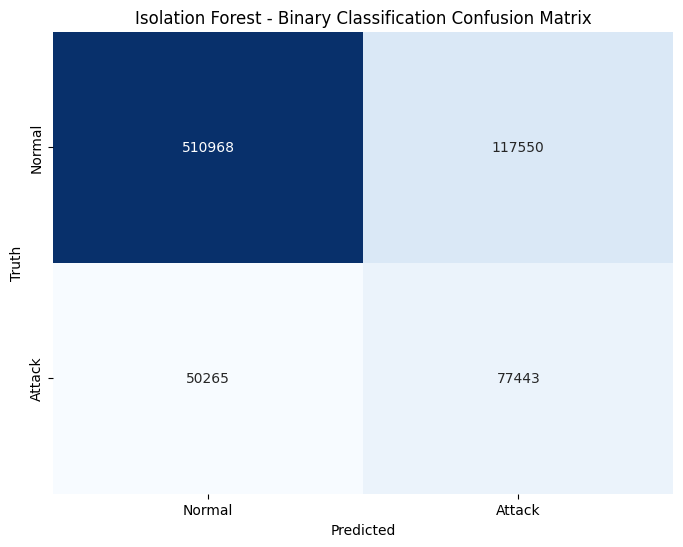

In [22]:
# Confusion Matrix for Binary Classification
cm_if_binary = confusion_matrix(y_test_bin, y_pred_if)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_if_binary, annot=True, fmt='d', 
            xticklabels=['Normal', 'Attack'], 
            yticklabels=['Normal', 'Attack'], 
            cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('Isolation Forest - Binary Classification Confusion Matrix')
plt.show()

In [23]:
# Classification report
print(classification_report(y_test_bin, y_pred_if, target_names=['Normal', 'Attack']))

              precision    recall  f1-score   support

      Normal       0.91      0.81      0.86    628518
      Attack       0.40      0.61      0.48    127708

    accuracy                           0.78    756226
   macro avg       0.65      0.71      0.67    756226
weighted avg       0.82      0.78      0.79    756226



The results show that the model achieves a **precision of 0.91** and a **recall of 0.81** for the **Normal** class, indicating that it is highly accurate when identifying normal instances but still misses some of them (the recall of 0.81). For the **Attack** class, the precision is lower at **0.40**, meaning that a significant proportion of predicted attacks are false positives (i.e., normal instances are incorrectly labeled as attacks). However, the **recall for the Attack class is 0.61**, meaning that the model correctly identifies 61% of the actual attacks, but there is still room for improvement in reducing false negatives.

Overall, the model has a **f1-score of 0.86** for the Normal class and **0.48** for the Attack class, reflecting the trade-off between precision and recall. The **accuracy** of **0.78** suggests that, although the model performs reasonably well, it still struggles with balancing the identification of both classes, especially the minority class (Attack). The **macro average f1-score** of **0.67** and **weighted average f1-score** of **0.79** show that, despite the imbalance, the model does a good job of overall performance, though further optimization, such as adjusting thresholds or tuning hyperparameters, may improve the model’s ability to detect attacks without sacrificing too much precision.

**Remember these numbers might differ at each training iteration.**

**Taking the results gathered by Sirisha et al. (2021) as a benchmark, this is how the IF trained here compares:**

| **Model**            | **Accuracy** | **Precision (Normal)** | **Precision (Anomaly)** | **Recall (Normal)** | **Recall (Anomaly)** | **F1 Score (Normal)** | **F1 Score (Anomaly)** |
|----------------------|--------------|------------------------|-------------------------|---------------------|----------------------|-----------------------|------------------------|
| **Reference (IF)**   | 0.79         | 0.45                   | 0.83                    | 0.23                | 0.93                 | 0.30                  | 0.88                   |
| **IF (this notebook)**          | 0.78         | 0.91                   | 0.40                    | 0.81                | 0.61                 | 0.86                  | 0.48        |


The Isolation Forest (IF) model trained in this notebook shows a slight drop in accuracy (0.78 vs 0.79) compared to the benchmark. However, it significantly outperforms the reference in precision for normal traffic (0.91 vs 0.45) and recall for normal traffic (0.81 vs 0.23), indicating a more effective identification of normal behavior. On the other hand, anomaly precision (0.40 vs 0.83) and anomaly recall (0.61 vs 0.93) are notably lower in this notebook, pointing to a trade-off in the detection of anomalies. Despite these differences, the F1 score for both normal and anomaly classes in this notebook is more balanced. The model overall demonstrates improved detection of normal traffic, which is crucial for many practical applications. By adjusting the decision threshold, it is possible to achieve very similar results to those of the benchmark, offering flexibility depending on the desired behavior for the potential Network Intrusion Detection System (NIDS).

### 2.1.3 Exporting the Model

In [24]:
# Save the model to a file
joblib.dump(if_model, 'isolation_forest.joblib')

['isolation_forest.joblib']

## 2.2. K-means

K-means is an unsupervised learning algorithm that partitions data into __k__ distinct clusters based on distance metrics. Unlike supervised methods like Random Forest and XGBoost, K-means doesn't require labeled data for training, making it suitable for anomaly detection in scenarios where labeled data is scarce or unavailable.
In the context of NIDS, K-means can be effective for detecting network anomalies by clustering normal traffic into one group and potentially separating different attack types into other clusters. This approach can help identify previously unseen attack patterns that supervised models might miss.

### 2.2.1. Finding Optimal Number of Clusters
K-means requires specifying the number of clusters beforehand. Although our dataset contains 7 classes after the preprocessing phase (Normal Traffic, DoS, DDoS, Port Scanning, Brute Force, Web Attacks, and Bots), it's important to determine if this is the optimal number of clusters from an unsupervised perspective. We'll use multiple evaluation metrics to find the best value of __k__.

In [25]:
# Find optimal k
k_range = range(2, 15)
results = find_optimal_k(X_train_scaled, k_range)

Testing with k=2...
Testing with k=3...
Testing with k=4...
Testing with k=5...
Testing with k=6...
Testing with k=7...
Testing with k=8...
Testing with k=9...
Testing with k=10...
Testing with k=11...
Testing with k=12...
Testing with k=13...
Testing with k=14...


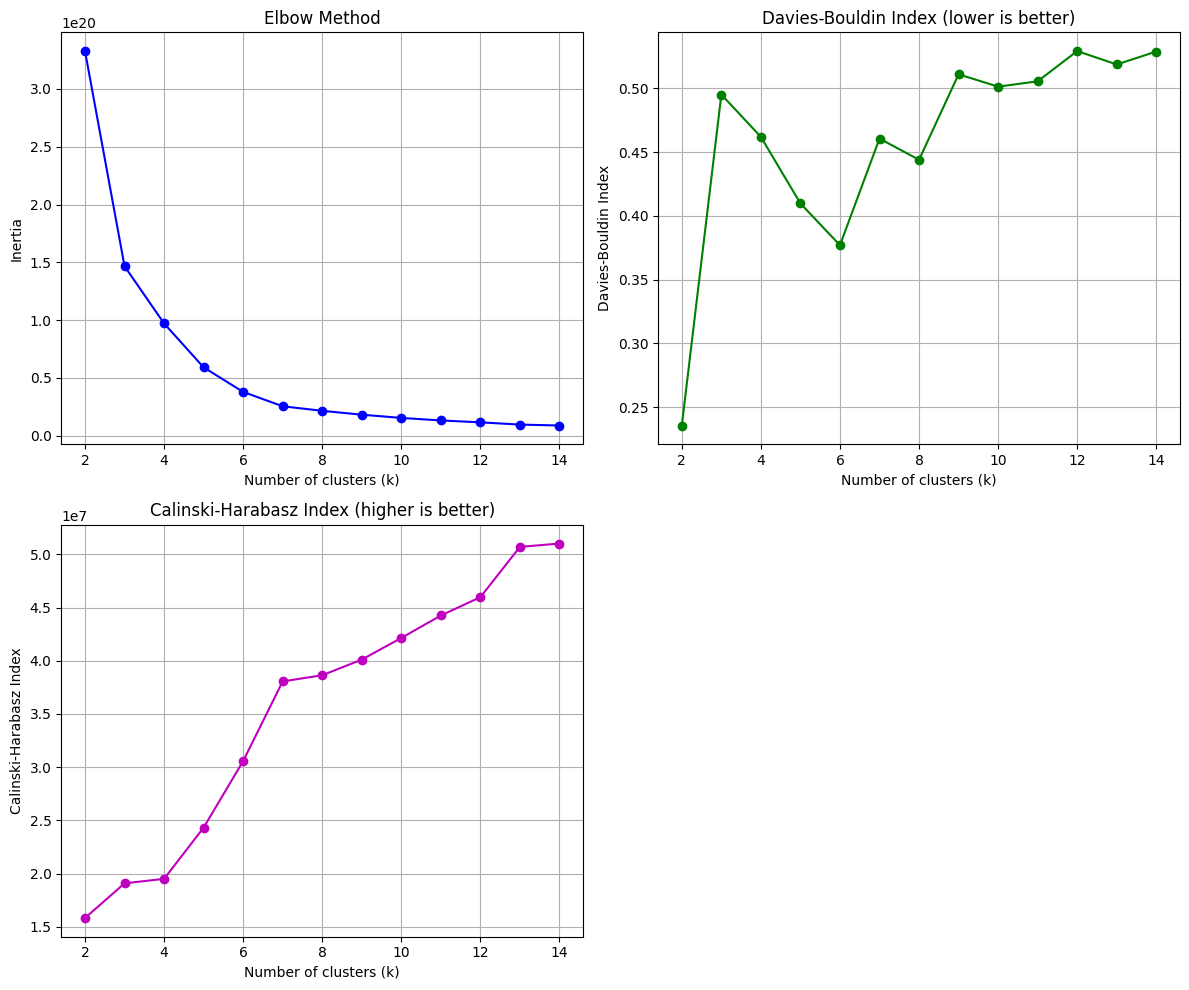

In [26]:
# Plotting results
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot inertia (Elbow method)
axes[0, 0].plot(results['k_values'], results['inertia'], 'bo-')
axes[0, 0].set_xlabel('Number of clusters (k)')
axes[0, 0].set_ylabel('Inertia')
axes[0, 0].set_title('Elbow Method')
axes[0, 0].grid(True)

# Plot Davies-Bouldin index
axes[0, 1].plot(results['k_values'], results['davies_bouldin'], 'go-')
axes[0, 1].set_xlabel('Number of clusters (k)')
axes[0, 1].set_ylabel('Davies-Bouldin Index')
axes[0, 1].set_title('Davies-Bouldin Index (lower is better)')
axes[0, 1].grid(True)

# Plot Calinski-Harabasz index
axes[1, 0].plot(results['k_values'], results['calinski_harabasz'], 'mo-')
axes[1, 0].set_xlabel('Number of clusters (k)')
axes[1, 0].set_ylabel('Calinski-Harabasz Index')
axes[1, 0].set_title('Calinski-Harabasz Index (higher is better)')
axes[1, 0].grid(True)

fig.delaxes(axes[1, 1])
plt.tight_layout()
plt.show()

The results from the **Elbow method**, **Davies-Bouldin index**, and **Calinski-Harabasz index** present a nuanced picture of cluster selection. The **Elbow method** suggests a potential break at **k=3**, although the curve indicates that the dataset may exhibit multiple cluster structures. The **Davies-Bouldin index**, favoring **k=2**, highlights the challenge of achieving a clear cluster distinction. However, it also shows a decline at **k=6**, which may point to a meaningful shift in the cluster configuration. Meanwhile, the **Calinski-Harabasz index** demonstrates slower growth at **k=7**, suggesting that separations beyond this point might be less meaningful. Interestingly, the tendency changes again at **k=12**, indicating some possible meaningful structure beyond **k=7**.

Given the inconsistencies across these metrics, the model was trained based on the results from the **Elbow method**, selecting **k=3**. Locally, iterative training showed the best results at this value of **k**, and you are welcome to reproduce this if desired.


### 2.2.2. Fitting the K-means Model
For K-means, we'll use the scaled features as it's a distance-based algorithm.

In [27]:
# Fitting the model
kmeans_model, cluster_labels, measurement_kmeans = apply_kmeans(X_train_scaled, n_clusters=3)

# Making predictions on test set
test_cluster_labels = kmeans_model.predict(X_test_scaled)

In [28]:
# Determine the "Normal" Cluster
cluster_counts = pd.Series(cluster_labels).value_counts()

# Assume the largest cluster is "normal"
normal_cluster = cluster_counts.idxmax()


In [29]:
# Assign "0" to the normal cluster and "1" to all other clusters
y_pred_kmeans = (test_cluster_labels != normal_cluster).astype(int)

In [30]:
# Evaluating computational cost
print("Resource measurements:", measurement_kmeans)

Resource measurements: {'Memory Usage (MB)': 3952.8828125, 'Training Time (s)': 3.017977476119995, 'Peak CPU Usage (%)': 100.0, 'Average CPU Usage (%)': 62.00666666666667}


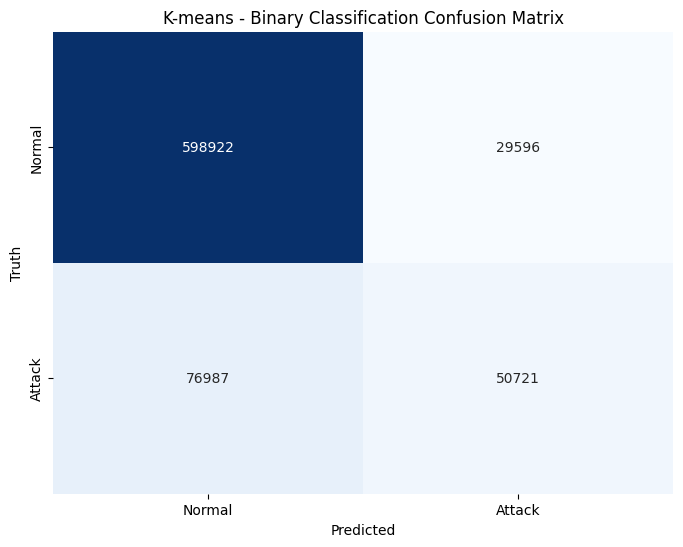

In [31]:
# Confusion Matrix for Binary Classification
cm_kmeans = confusion_matrix(y_test_bin, y_pred_kmeans)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_kmeans, annot=True, fmt='d', 
            xticklabels=['Normal', 'Attack'], 
            yticklabels=['Normal', 'Attack'], 
            cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('K-means - Binary Classification Confusion Matrix')
plt.show()

In [32]:
# Classification report
print(classification_report(y_test_bin, y_pred_kmeans, target_names=['Normal', 'Attack']))

              precision    recall  f1-score   support

      Normal       0.89      0.95      0.92    628518
      Attack       0.63      0.40      0.49    127708

    accuracy                           0.86    756226
   macro avg       0.76      0.68      0.70    756226
weighted avg       0.84      0.86      0.85    756226



Based on the results of the K-Means clustering, we observe a high accuracy of 86%, with significant performance differences between the normal and attack classes. The model performs well in identifying **normal traffic** with high precision (0.89), recall (0.95), and F1-score (0.92), which suggests that the normal traffic cluster is well-defined and distinct in the feature space. However, for the **attack class**, the performance metrics are noticeably weaker, with a precision of 0.63, recall of 0.40, and F1-score of 0.49. This indicates that the model struggles to accurately identify and separate attack traffic from normal traffic, possibly due to the absence of clear boundaries between attack types and normal behavior. The relatively low recall for attacks suggests that K-Means may not be capturing all of the anomalous behavior, leading to a higher false negative rate. 

The **macro average** of 0.76 for precision, 0.68 for recall, and 0.70 for F1-score reflects the imbalance between the performance on normal and attack classes. The **weighted average**, however, indicates a more favorable overall performance (0.84 for precision, 0.86 for recall, and 0.85 for F1-score), which is driven by the model's stronger performance on normal traffic. In conclusion, while K-Means shows decent overall accuracy, it struggles with the detection of attack traffic, suggesting that the model may benefit from further tuning or the use of a different clustering algorithm that can better handle the complexity and imbalance inherent in the **CICIDS2017** dataset.

**Taking the results gathered by Sirisha et al. (2021) as a benchmark, this is how the K-Means model trained here compares:**

| **Model**            | **Accuracy** | **Precision (Normal)** | **Precision (Anomaly)** | **Recall (Normal)** | **Recall (Anomaly)** | **F1 Score (Normal)** | **F1 Score (Anomaly)** | 
|----------------------|--------------|------------------------|-------------------------|---------------------|----------------------|-----------------------|------------------------|
| **Reference (K-Means)** | 0.79         | 0.84                   | 0.46                    | 0.91                | 0.31                 | 0.88                  | 0.37                   |
| **K-Means (this notebook)**      | 0.86         | 0.89                   | 0.63                    | 0.95                | 0.40                 | 0.92                  | 0.49                   |


The K-Means model trained in this notebook shows a notable improvement in accuracy (0.86 vs 0.79) compared to the benchmark. It significantly outperforms the reference in precision for both normal traffic (0.89 vs 0.84) and anomalies (0.63 vs 0.46), as well as in recall for normal traffic (0.95 vs 0.91), suggesting more effective identification of normal behavior and anomalies. The model demonstrates better detection capabilities across both normal and anomalous traffic, making it better-suited for practical applications where distinguishing between normal traffic and attacks is crucial.

### 2.2.3. Exporting the Model

In [33]:
# Save the model and scaler to files
joblib.dump(kmeans_model, 'kmeans_model.joblib')

['kmeans_model.joblib']

# 3. Comparing Performance Results

In [34]:
# Calculating precision, recall, and F1 score for each unsupervised model
precision_if = precision_score(y_test_bin, y_pred_if, average='weighted')
recall_if = recall_score(y_test_bin, y_pred_if, average='weighted')
f1_if = f1_score(y_test_bin, y_pred_if, average='weighted')
accuracy_if = accuracy_score(y_test_bin, y_pred_if)

precision_kmeans = precision_score(y_test_bin, y_pred_kmeans, average='weighted')
recall_kmeans = recall_score(y_test_bin, y_pred_kmeans, average='weighted')
f1_kmeans = f1_score(y_test_bin, y_pred_kmeans, average='weighted')
accuracy_kmeans = accuracy_score(y_test_bin, y_pred_kmeans)

In [35]:
# Creating the results dataframe
unsupervised_results = pd.DataFrame({
    'Model': ['Isolation Forest', 'K-Means'],
    'Accuracy': [accuracy_if, accuracy_kmeans],
    'Precision': [precision_if, precision_kmeans],
    'Recall': [recall_if, recall_kmeans],
    'F1 Score': [f1_if, f1_kmeans],
    'Memory Usage (MB)': [measurement_if['Memory Usage (MB)'], measurement_kmeans['Memory Usage (MB)']],
    'Training Time (s)': [measurement_if['Training Time (s)'], measurement_kmeans['Training Time (s)']],
    'Peak CPU Usage (%)': [measurement_if['Peak CPU Usage (%)'], measurement_kmeans['Peak CPU Usage (%)']],
    'Average CPU Usage (%)': [measurement_if['Average CPU Usage (%)'], measurement_kmeans['Average CPU Usage (%)']],
})

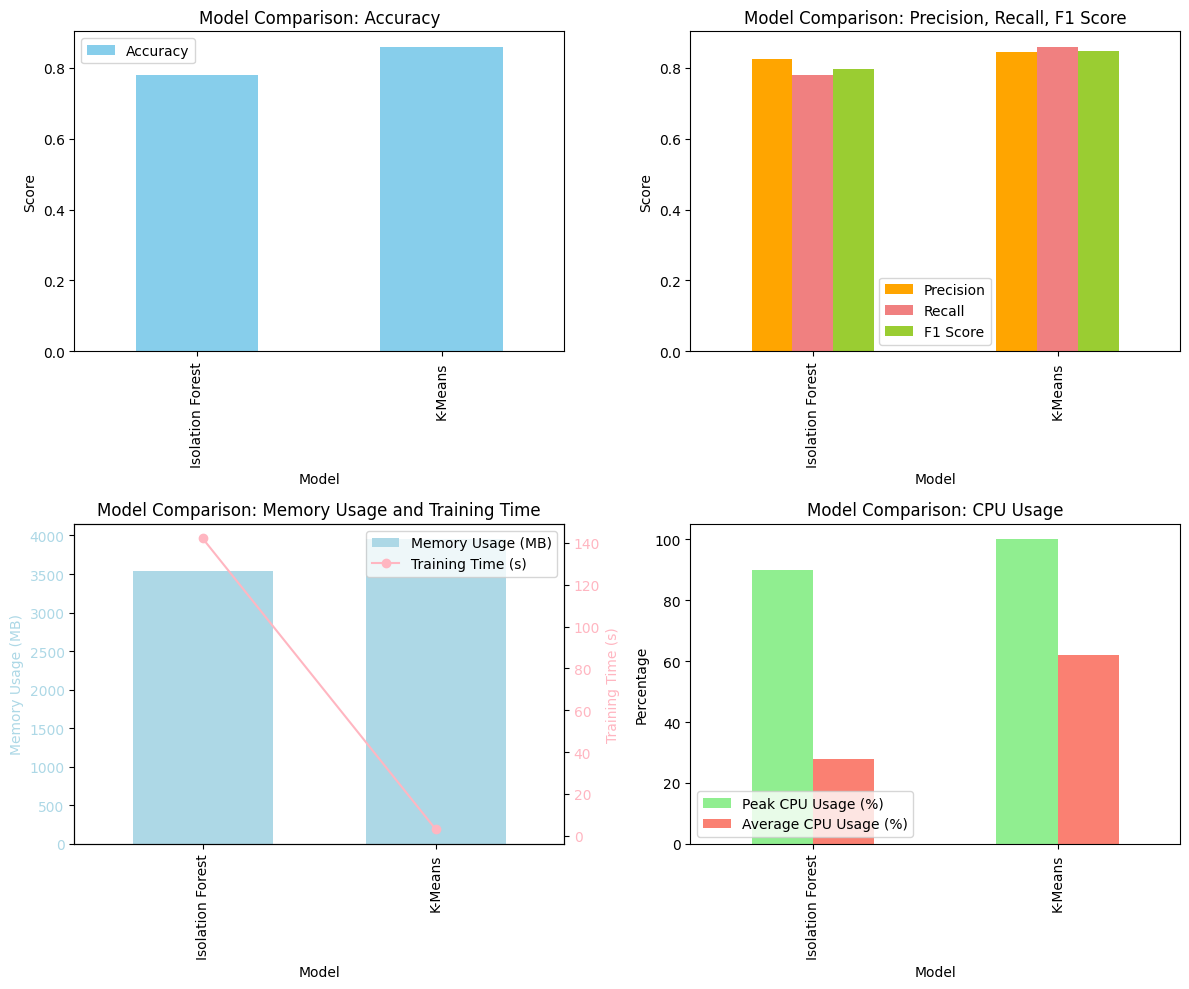

In [36]:
# Plotting the comparison for accuracy, metrics, and performance
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plotting Accuracy
unsupervised_results.set_index('Model')['Accuracy'].plot(kind='bar', ax=axes[0, 0], color='skyblue', legend=True)
axes[0, 0].set_title('Model Comparison: Accuracy')
axes[0, 0].set_ylabel('Score')
axes[0, 0].set_xlabel('Model')

# Plotting Precision, Recall, F1 Score
unsupervised_results.set_index('Model')[['Precision', 'Recall', 'F1 Score']].plot(kind='bar', ax=axes[0, 1], color=['orange', 'lightcoral', 'yellowgreen'], legend=True)
axes[0, 1].set_title('Model Comparison: Precision, Recall, F1 Score')
axes[0, 1].set_ylabel('Score')
axes[0, 1].set_xlabel('Model')

# Plotting Memory Usage and Training Time
ax1 = axes[1, 0]

unsupervised_results.set_index('Model')['Memory Usage (MB)'].plot(
    kind='bar', ax=ax1, color='lightblue', label='Memory Usage (MB)', width=0.6
)
ax1.set_ylabel('Memory Usage (MB)', color='lightblue')
ax1.tick_params(axis='y', labelcolor='lightblue')

ax2 = ax1.twinx() 
unsupervised_results.set_index('Model')['Training Time (s)'].plot(
    ax=ax2, color='lightpink', marker='o', label='Training Time (s)'
)
ax2.set_ylabel('Training Time (s)', color='lightpink')
ax2.tick_params(axis='y', labelcolor='lightpink')

ax1.set_title('Model Comparison: Memory Usage and Training Time')
ax1.set_xlabel('Model')

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper right')

# Plotting Peak and Average CPU Usage
unsupervised_results.set_index('Model')[['Peak CPU Usage (%)', 'Average CPU Usage (%)']].plot(kind='bar', ax=axes[1, 1], color=['lightgreen', 'salmon'], legend=True)
axes[1, 1].set_title('Model Comparison: CPU Usage')
axes[1, 1].set_ylabel('Percentage')
axes[1, 1].set_xlabel('Model')
axes[1, 1].legend(loc='lower left')

plt.tight_layout()
plt.show()

**Detection Performance Analysis:**

The unsupervised learning algorithms, Isolation Forest (IF) and K-Means, showed noticeably lower performance compared to the supervised models previously trained. This outcome aligns with findings in the literature, particularly in the context of the CICIDS2017 dataset, where unsupervised methods often struggle. Despite promising results being reported in other datasets, such as UNSW-NB15, the CICIDS2017 dataset presents unique challenges, particularly in terms of attack class overlap and the absence of clear boundaries between normal and anomalous traffic.

A deeper data treatment could potentially improve the results. This could include more careful feature engineering and selection, focusing on identifying the most relevant features that contribute to anomaly detection. Additionally, techniques like dimensionality reduction, outlier filtering, or feature transformation could help enhance the model's ability to distinguish between normal and attack traffic.

**Computational Resources:**

In terms of computational efficiency, K-Means trains faster than Isolation Forest but is more demanding on system memory and CPU usage. This makes K-Means a more resource-intensive option, especially for large-scale datasets, whereas Isolation Forest offers a more balanced approach in terms of resource usage and detection performance. Notably, this is the only aspect in which the unsupervised algorithms outperform the supervised models (with the exception of K-NN, due to its 'lazy learner' characteristic, where training is deferred to the testing phase).

**Cited article**
- Sirisha, A., Chaitanya, K., ... Kanumalli, S.S., 2021. Intrusion detection models using supervised and unsupervised algorithms - A comparative estimation. International Journal of Safety and Security Engineering 11, 51–58. doi:10.18280/ijsse.110106